# Logistic regression

In [3]:
import sys
sys.path.append('../../Utilities/src')

from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import pandas as pd


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [5]:
from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *


In [6]:
data = pd.read_csv('log_reg_data.csv',index_col=0)

In [7]:
data.head()

,x1,x2,x3,x4,x5,hand,y
0,-0.318816,0.101644,-3.240568e-02,1.033146e-02,-3.293836e-03,1,1
1,0.823793,0.678635,5.590543e-01,4.605449e-01,3.793936e-01,1,1
2,-0.948920,0.900449,-8.544537e-01,8.108081e-01,-7.693919e-01,2,0
3,-0.601142,0.361371,-2.172353e-01,1.305892e-01,-7.850259e-02,1,1
4,-0.008257,0.000068,-5.629723e-07,4.648534e-09,-3.838354e-11,1,1


In [ ]:
data.describe()

### Prior selection


In [8]:
with open('logistic_regression_ppc.stan', 'r') as file:
    print(file.read())
model_ppc1 = CmdStanModel(stan_file='logistic_regression_ppc.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpf7ug7lu3/tmpbmpa6ll1
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
data {
  int<lower=1> N; // Number of observations
  int<lower=1> M; // Number of covariates
  matrix[N, M] X;             // Covariate design matrix
  real sigma; //prior standard deviation
}

transformed data {
  vector[N] ones_N = rep_vector(1, N);
  vector[M] ones_M = rep_vector(1, M);

}


// Simulate empirical probabilities from the current value of the parameters
generated quantities {
  vector[N] prob_ppc;
  {
  real beta[M] = normal_rng(0, ones_M*sigma);   // Prior model
  real alpha = normal_rng(0, sigma);   // Prior model
  prob_ppc = inv_logit(X * to_vector(beta) + ones_N*alpha);}
}

INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Logistic regression/logistic_regression_ppc


In [9]:
with open('logistic_regression_ppc2.stan', 'r') as file:
    print(file.read())
model_ppc2 = CmdStanModel(stan_file='logistic_regression_ppc2.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpagusieej/tmpeods0dhy
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
data {
  int<lower=1> N; // Number of observations
  int<lower=1> M; // Number of covariates
  matrix[N, M] X;             // Covariate design matrix
  real sigma; //prior standard deviation
}

transformed data {
  vector[N] ones_N = rep_vector(1, N);
  vector[M] ones_M = rep_vector(1, M);
}


// Simulate empirical probabilities from the current value of the parameters
generated quantities {
  vector[N] prob_ppc;
  {
  real beta[M] = student_t_rng(5,0,ones_M*sigma);   // Prior model
  real alpha = student_t_rng(5,0,sigma);   // Prior model
  prob_ppc = inv_logit(X * to_vector(beta) + ones_N*alpha);
}
}

INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Logistic regression/logistic_regression_ppc2


In [12]:
R=1000
data_ppc= dict(N = data.shape[0],
                 M = 5,
                 X = data.iloc[:,0:5].values,
                 sigma=10)
sim_ppc1=model_ppc1.sample(data=data_ppc, 
                           iter_sampling=R, iter_warmup=0, 
                           chains=1, 
                           refresh=R,
                           fixed_param=True,
                           seed=29042020)

sim_ppc2=model_ppc2.sample(data=data_ppc, 
                           iter_sampling=R, iter_warmup=0, 
                           chains=1, 
                           refresh=R,
                           fixed_param=True,
                           seed=29042020)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1


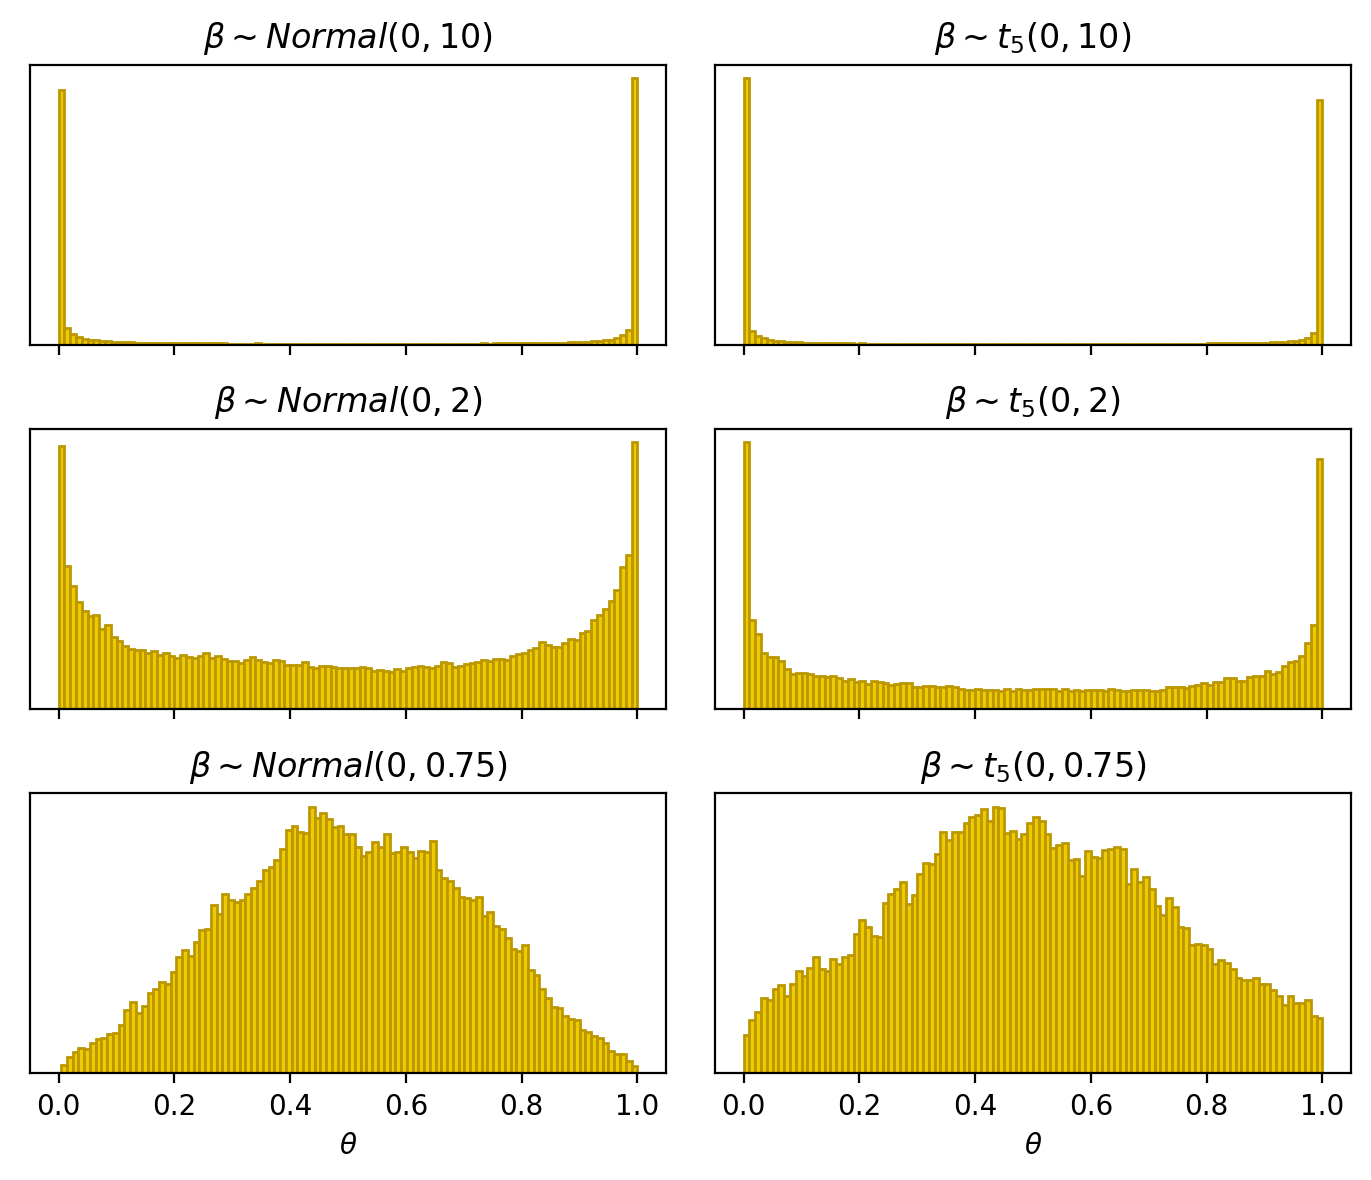

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(7, 6),sharex=True)
sigmas=[10,2,0.75]
for k in range(3):
    data_ppc['sigma']=sigmas[k]
    sim_ppc1=model_ppc1.sample(data=data_ppc, 
                           iter_sampling=R, iter_warmup=0, 
                           chains=1, 
                           refresh=R,
                           fixed_param=True,
                           seed=29042020)
    sim_ppc2=model_ppc2.sample(data=data_ppc, 
                           iter_sampling=R, iter_warmup=0, 
                           chains=1, 
                           refresh=R,
                           fixed_param=True,
                           seed=29042020)
    axes[k,0].hist(sim_ppc1.stan_variable('prob_ppc').flatten(),bins=100,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    axes[k,0].set_yticks([])
    axes[k,0].set_title(r'$\beta\sim Normal(0,{})$'.format(sigmas[k]))    
    axes[k,1].hist(sim_ppc2.stan_variable('prob_ppc').flatten(),bins=100,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    axes[k,1].set_yticks([])
    axes[k,1].set_title(r'$\beta\sim t_5(0,{})$'.format(sigmas[k]))
axes[2,0].set_xlabel(r'$\theta$')
axes[2,1].set_xlabel(r'$\theta$')

fig.tight_layout()
plt.show()

### Posterior inference and simulation

In [16]:
with open('logistic_regression.stan', 'r') as file:
    print(file.read())

data {
  int<lower=1> N; // Number of observations
  int<lower=1> M; // Number of covariates

  matrix[N, M] X;             // Covariate design matrix
  int<lower=0, upper=1> y[N]; // Binary variates

  int<lower=1> N_hand;           // Number of handedness groups
  int<lower=1, upper=2> hand[N]; // Handedness group assignments
}

transformed data {
  vector[N] ones_N = rep_vector(1, N);
}

parameters {
  vector[M] beta;      // Slopes
  real alpha;          // Intercept
}


model {
  beta ~ normal(0, 0.75);   // Prior model
  alpha ~ normal(0, 0.75);  // Prior model
  y ~ bernoulli_logit(X * beta + alpha);  // Observational model
}

// Simulate empirical probabilities from the current value of the parameters
generated quantities {
  real p_hat_ppc = 0;
  real p_hat_left_ppc = 0;
  real p_hat_right_ppc = 0;
  int y_ppc[N] = bernoulli_logit_rng(X * beta + ones_N*alpha);
  vector[N] prob_ppc = inv_logit(X * beta + ones_N*alpha);
  {
    int n_left = 0;
    int n_right = 0;

    for (n in

In [17]:
model = CmdStanModel(stan_file='logistic_regression.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmp4_gsyglq/tmp3f5tpchd
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /Users/jerzybaranowski/GitHub/KAIR-ISZ/public_lectures/Data Analytics/Topic 7 - Generalized linear models/Logistic regression/logistic_regression


In [21]:
data_dict = dict(N = data.shape[0],
                 M = 5,
                 X = data.iloc[:,0:5].values,
                 y = data.y.values,
                 N_hand = 2,
                 hand = data.hand.values)
fit = model.sample(data=data_dict, seed=4938483)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4


In [22]:
pars_mat=np.concatenate((fit.stan_variable('beta'),np.expand_dims(fit.stan_variable('alpha'),axis=1)),axis=1)

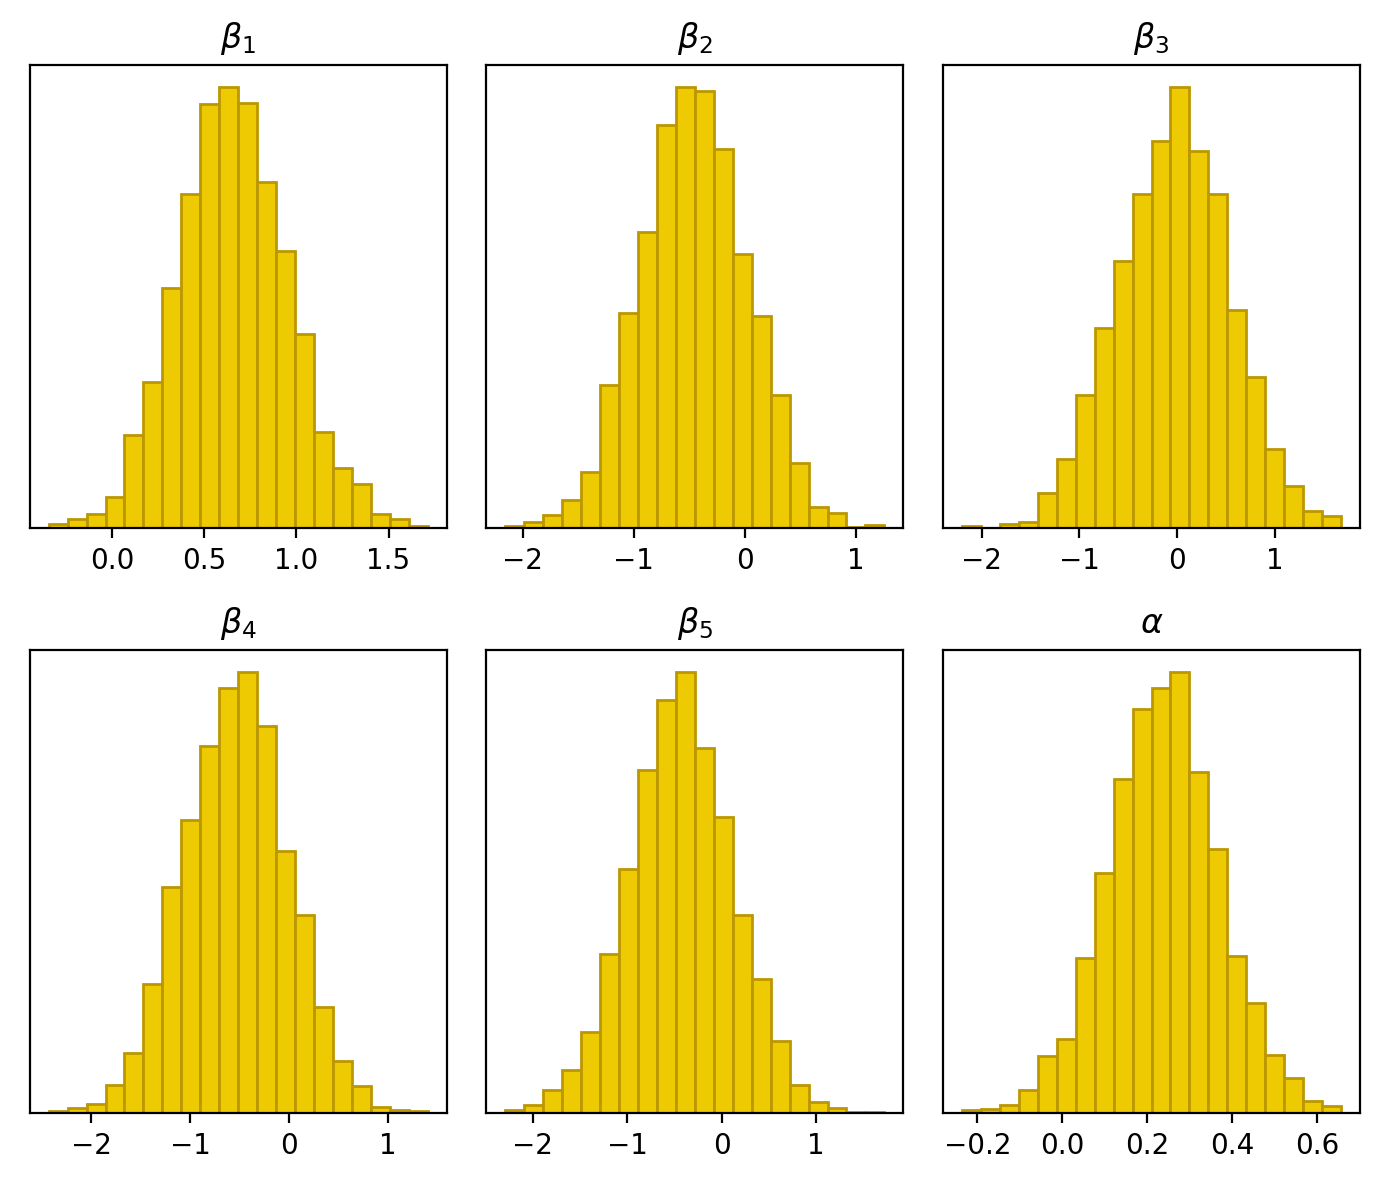

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(7, 6))
axes_flat=axes.flatten()
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\beta_4$',r'$\beta_5$',r'$\alpha$']
for k in range(len(axes_flat)):
    ax = axes_flat[k]
    ax.hist(pars_mat[:,k],bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.tight_layout()

plt.show()

### Estimation of group parameters

In [24]:
counts = len(data['y'])
bin_delta = 1.0 / counts
bins = np.arange(0 - 0.5 * bin_delta, 1 + 1.5 * bin_delta, bin_delta)



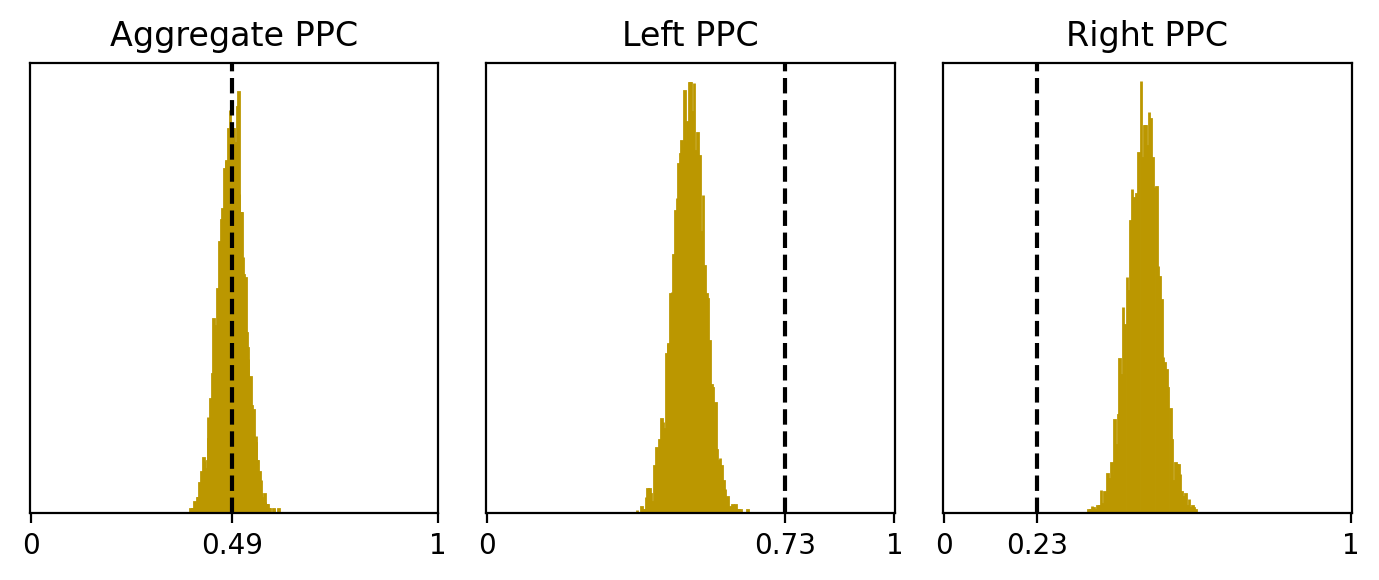

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(7, 3))
ax1=axes[0]
group_mean = data.y.mean()
h_counts = ax1.hist(fit.stan_variable('p_hat_ppc'),bins=bins,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True,zorder=0)
y_max = np.max(h_counts[0])
ax1.vlines(group_mean,0,y_max+1,color='black',linestyle='--',linewidth=1.5,zorder=2)
ax1.set_title("Aggregate PPC")
ax1.set_xlim([-bin_delta, 1 + bin_delta])
ax1.set_ylim([0, y_max + 1])
ax1.set_xticks([0,group_mean,1])
ax1.set_xticklabels([0,'{0:1.2f}'.format(group_mean),1])
ax1.set_yticks([])

ax2=axes[1]
left_mean = data[data.hand==1].y.mean()
h_counts = ax2.hist(fit.stan_variable('p_hat_left_ppc'),bins=bins,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True,zorder=0)
y_max = np.max(h_counts[0])
ax2.vlines(left_mean,0,y_max+1,color='black',linestyle='--',linewidth=1.5,zorder=2)
ax2.set_title("Left PPC")
ax2.set_xlim([-bin_delta, 1 + bin_delta])
ax2.set_ylim([0, y_max + 1])
ax2.set_xticks([0,left_mean,1])
ax2.set_xticklabels([0,'{0:1.2f}'.format(left_mean),1])
ax2.set_yticks([])


ax3=axes[2]
right_mean = data[data.hand==2].y.mean()
h_counts = ax3.hist(fit.stan_variable('p_hat_right_ppc'),bins=bins,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True,zorder=0)
y_max = np.max(h_counts[0])
ax3.vlines(right_mean,0,y_max+1,color='black',linestyle='--',linewidth=1.5,zorder=2)
ax3.set_title("Right PPC")
ax3.set_xlim([-bin_delta, 1 + bin_delta])
ax3.set_ylim([0, y_max + 1])
ax3.set_xticks([0,right_mean,1])
ax3.set_xticklabels([0,'{0:1.2f}'.format(right_mean),1])

ax3.set_yticks([])

fig.tight_layout()

plt.show()

### Individual predictions

In [28]:
med_prob_ppc = np.percentile(fit.stan_variable('prob_ppc'),[25,50,75],axis=0)
estimate_ppc_df = pd.DataFrame(med_prob_ppc.T,columns = ['lo','med','hi'])
estimate_ppc_df['y'] = data.y
estimate_ppc_df.sort_values(by='med',inplace=True)
estimate_ppc_df

error_bar=np.array((
                    (estimate_ppc_df['med']-estimate_ppc_df['lo']).values,
                    (estimate_ppc_df['hi']-estimate_ppc_df['med']).values))


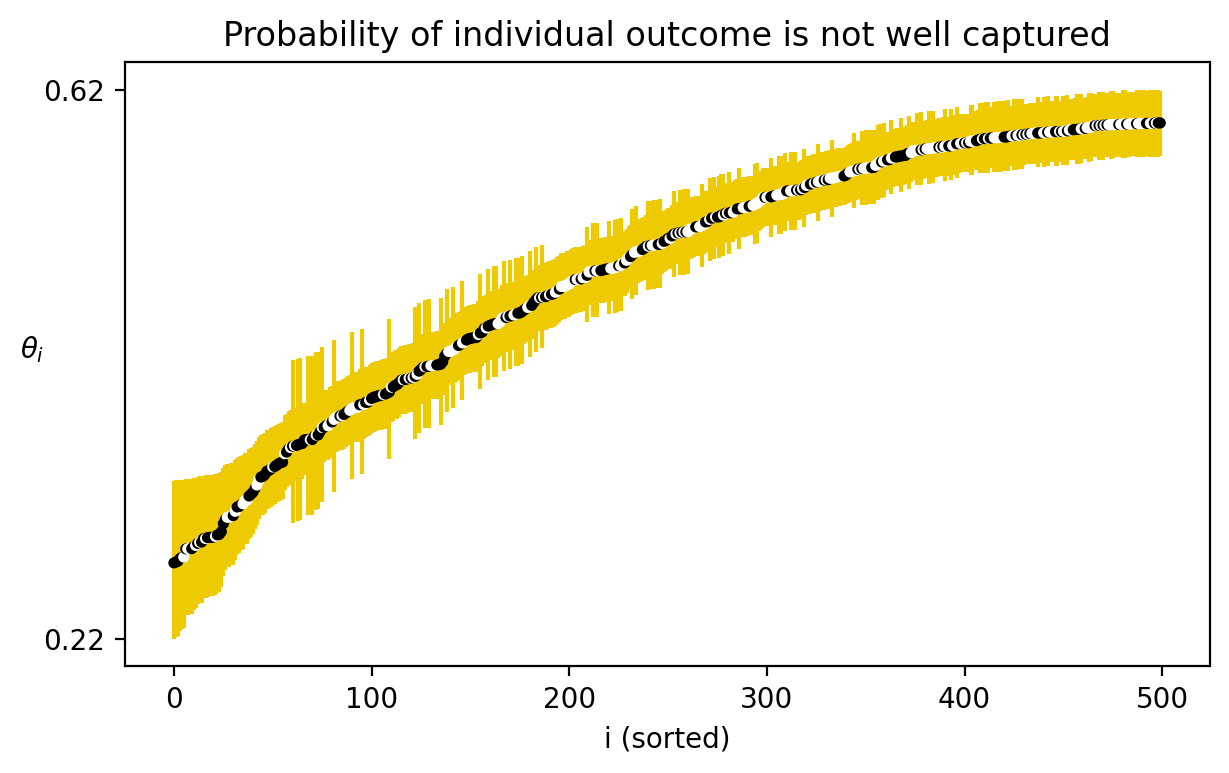

In [29]:
fig, axes = plt.subplots(1,1, figsize=(7, 4),sharex=True)

axes.scatter([*range(500)],estimate_ppc_df.med,marker='.',c=[(1.*k,1.*k,1.*k) for k in estimate_ppc_df.y])
axes.errorbar([*range(500)],estimate_ppc_df.med,yerr=error_bar,fmt='none',zorder=0,ecolor=DARK)
axes.set_title('Probability of individual outcome is not well captured')
axes.set_ylabel(r'$\theta_i$',rotation=0)
axes.set_yticks([estimate_ppc_df['lo'].min(),estimate_ppc_df['hi'].max()])
axes.set_yticklabels(['{0:1.2}'.format(estimate_ppc_df['lo'].min()),'{0:1.2}'.format(estimate_ppc_df['hi'].max())])
axes.set_xlabel('i (sorted)')
plt.show()

### Introduction of grouping

In [32]:
with open('grouped_logistic_regression.stan', 'r') as file:
    print(file.read())
model2 = CmdStanModel(stan_file='grouped_logistic_regression.stan')

INFO:cmdstanpy:compiling stan program, exe file: /var/folders/j5/wr2j95x534x62nm4sfx97cbc0000gn/T/tmpon37b11q/tmps2etk6rq
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
data {
  int<lower=1> N; // Number of observations
  int<lower=1> M; // Number of covariates

  matrix[N, M] X;             // Covariate design matrix
  int<lower=0, upper=1> y[N]; // Binary variates

  int<lower=1> N_hand;           // Number of handedness groups
  int<lower=1, upper=2> hand[N]; // Handedness group assignments
}
transformed data {
  vector[N] ones_N = rep_vector(1, N);
}
parameters {
  vector[M] beta;        // Slopes
  vector[N_hand] alpha;  // Intercepts for each handedness group
}

model {
  beta ~ normal(0, 0.75);   // Prior model
  alpha ~ normal(0, 0.75);  // Prior model
  y ~ bernoulli_logit(X * beta + alpha[hand]);  // Observational model
}

// Simulate empirical probabilities from the current value of the parameters
generated quantities {
  real p_hat_ppc = 0;
  real p_h

In [33]:
fit2 = model2.sample(data=data_dict, seed=4938483)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [35]:
pars_mat2=np.concatenate((fit2.stan_variable('beta'),fit2.stan_variable('alpha')),axis=1)



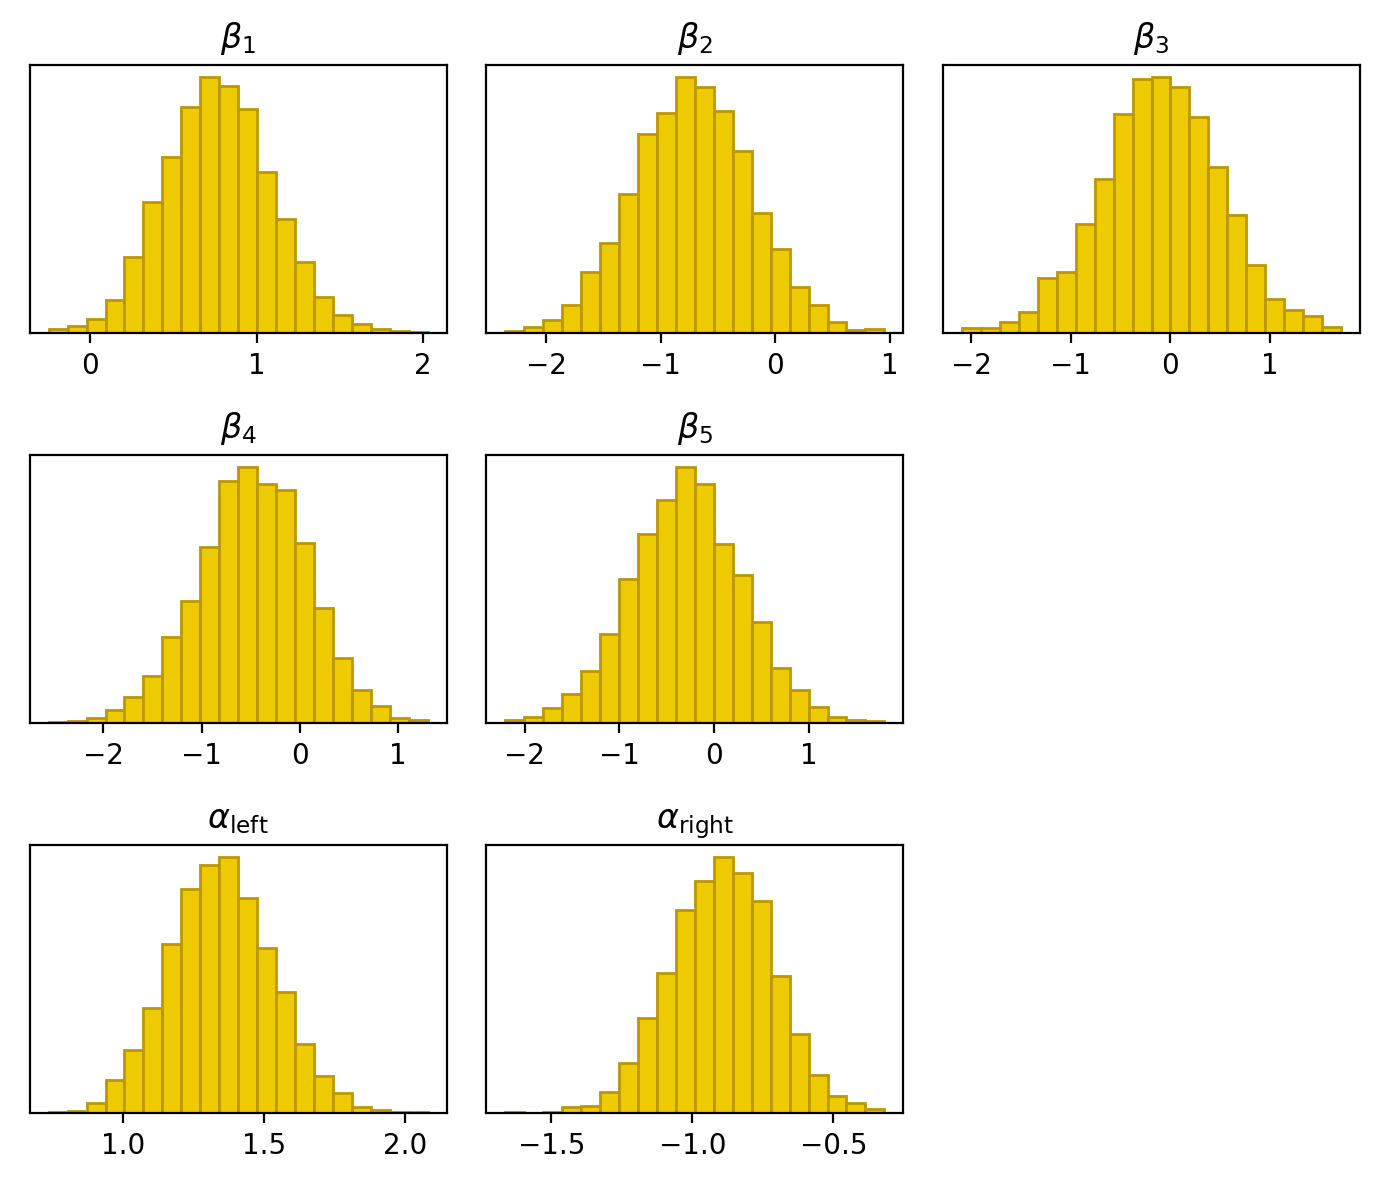

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(7, 6))
axes_flat = axes.flatten()
axes_sort = np.concatenate((axes_flat[:5],axes_flat[6:8]))
names_of_pars = [r'$\beta_1$',r'$\beta_2$',r'$\beta_3$',r'$\beta_4$',r'$\beta_5$',r'$\alpha_\mathrm{left}$', r'$\alpha_\mathrm{right}$']
for k in range(pars_mat2.shape[1]):
    ax = axes_sort[k]
    ax.hist(pars_mat2[:,k],bins=20,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True)
    ax.set_title(names_of_pars[k])
    ax.set_yticks([])
fig.delaxes(axes[1,2])
fig.delaxes(axes[2,2])

fig.tight_layout()

plt.show()

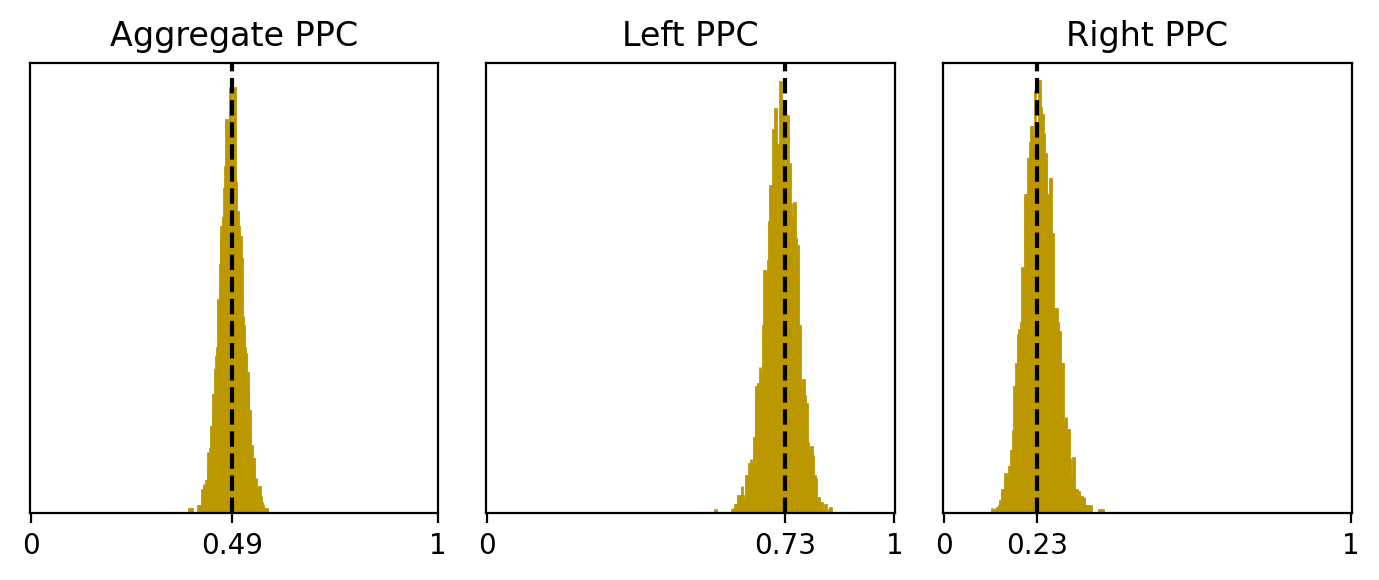

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(7, 3))
ax1=axes[0]
group_mean = data.y.mean()
h_counts = ax1.hist(fit2.stan_variable('p_hat_ppc'),bins=bins,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True,zorder=0)
y_max = np.max(h_counts[0])
ax1.vlines(group_mean,0,y_max+1,color='black',linestyle='--',linewidth=1.5,zorder=2)
ax1.set_title("Aggregate PPC")
ax1.set_xlim([-bin_delta, 1 + bin_delta])
ax1.set_ylim([0, y_max + 1])
ax1.set_xticks([0,group_mean,1])
ax1.set_xticklabels([0,'{0:1.2f}'.format(group_mean),1])
ax1.set_yticks([])

ax2=axes[1]
left_mean = data[data.hand==1].y.mean()
h_counts = ax2.hist(fit2.stan_variable('p_hat_left_ppc'),bins=bins,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True,zorder=0)
y_max = np.max(h_counts[0])
ax2.vlines(left_mean,0,y_max+1,color='black',linestyle='--',linewidth=1.5,zorder=2)
ax2.set_title("Left PPC")
ax2.set_xlim([-bin_delta, 1 + bin_delta])
ax2.set_ylim([0, y_max + 1])
ax2.set_xticks([0,left_mean,1])
ax2.set_xticklabels([0,'{0:1.2f}'.format(left_mean),1])
ax2.set_yticks([])


ax3=axes[2]
right_mean = data[data.hand==2].y.mean()
h_counts = ax3.hist(fit2.stan_variable('p_hat_right_ppc'),bins=bins,color=DARK,edgecolor=DARK_HIGHLIGHT,density=True,zorder=0)
y_max = np.max(h_counts[0])
ax3.vlines(right_mean,0,y_max+1,color='black',linestyle='--',linewidth=1.5,zorder=2)
ax3.set_title("Right PPC")
ax3.set_xlim([-bin_delta, 1 + bin_delta])
ax3.set_ylim([0, y_max + 1])
ax3.set_xticks([0,right_mean,1])
ax3.set_xticklabels([0,'{0:1.2f}'.format(right_mean),1])

ax3.set_yticks([])

fig.tight_layout()

plt.show()

In [39]:
med_prob_ppc = np.percentile(fit2.stan_variable('prob_ppc'),[25,50,75],axis=0)
estimate_ppc_df = pd.DataFrame(med_prob_ppc.T,columns = ['lo','med','hi'])
estimate_ppc_df['y'] = data.y
estimate_ppc_df.sort_values(by='med',inplace=True)
estimate_ppc_df

error_bar=np.array((
                    (estimate_ppc_df['med']-estimate_ppc_df['lo']).values,
                    (estimate_ppc_df['hi']-estimate_ppc_df['med']).values))


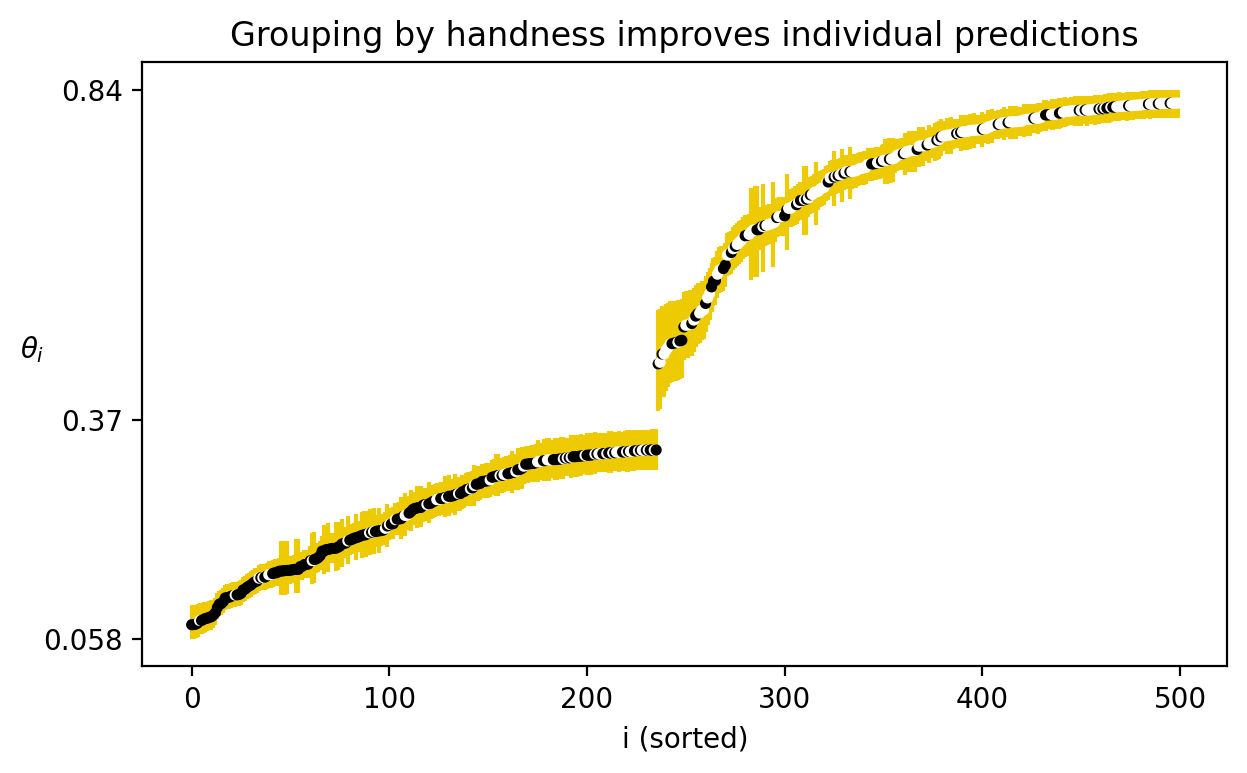

In [40]:
#plt.scatter([*range(500)],estimate_ppc_df.med,marker='.',c=[(1.*k,1.*k,1.*k) for k in estimate_ppc_df.y])
#plt.errorbar([*range(500)],estimate_ppc_df.med,yerr=error_bar,fmt='none',zorder=0,ecolor=DARK)


fig, axes = plt.subplots(1,1, figsize=(7, 4),sharex=True)

axes.scatter([*range(500)],estimate_ppc_df.med,marker='.',c=[(1.*k,1.*k,1.*k) for k in estimate_ppc_df.y])
axes.errorbar([*range(500)],estimate_ppc_df.med,yerr=error_bar,fmt='none',zorder=0,ecolor=DARK)
axes.set_title('Grouping by handness improves individual predictions')
axes.set_ylabel(r'$\theta_i$',rotation=0)
axes.set_yticks([estimate_ppc_df['lo'].min(),.37,estimate_ppc_df['hi'].max()])
axes.set_yticklabels(['{0:1.2}'.format(estimate_ppc_df['lo'].min()),'0.37','{0:1.2}'.format(estimate_ppc_df['hi'].max())])
axes.set_xlabel('i (sorted)')
plt.show()